In [7]:
# fixing import error using: https://stackoverflow.com/questions/71000250/import-tensorflow-keras-could-not-be-resolved-after-upgrading-to-tensorflow-2
import tensorflow.python.keras.layers
import tensorflow.python.keras.models
# https://blog.paperspace.com/autoencoder-image-compression-keras/
from sklearn import decomposition
import math
from math import sqrt
import pandas as pd
from sklearn.cluster import KMeans
# own modules
from text_embeddings.preprocessing.read_pdf import *
from user_interface.cli import *
from doc_images.pdf_matrix import *
from elasticSearch.queries.query_documents_tfidf import *
from text_embeddings.universal_sent_encoder_tensorFlow import *
from text_embeddings.hugging_face_sentence_transformer import *

image_src_path = '/Users/klara/Documents/Uni/bachelorarbeit/images/*.png'
IMG_SIZE = 300

In [8]:
image_paths = glob.glob(image_src_path)
preprocessed_images = np.array([np.reshape(a=
                                    cv2.normalize(
    cv2.resize(
        cv2.imread(img, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)), 
        None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        , newshape=IMG_SIZE**2) 
        for img in image_paths])

# center the images, cf. https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py
# Global centering (focus on one feature, centering all samples)
preprocessed_images_centered = preprocessed_images - np.mean(preprocessed_images, axis=0)
# Local centering (focus on one sample, centering all features)
preprocessed_images_centered -= preprocessed_images_centered.mean(axis=1).reshape(len(preprocessed_images_centered), -1)

In [9]:
x = tensorflow.keras.layers.Input(shape=(IMG_SIZE**2), name="encoder_input")

encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=2, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2)

In [10]:
encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

In [11]:
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 90000)]           0         
                                                                 
 encoder_dense_1 (Dense)     (None, 300)               27000300  
                                                                 
 encoder_leakyrelu_1 (Leaky  (None, 300)               0         
 ReLU)                                                           
                                                                 
 encoder_dense_2 (Dense)     (None, 2)                 602       
                                                                 
 encoder_output (LeakyReLU)  (None, 2)                 0         
                                                                 
Total params: 27000902 (103.00 MB)
Trainable params: 27000902 (103.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [12]:
decoder_input = tensorflow.keras.layers.Input(shape=(2), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=IMG_SIZE**2, name="decoder_dense_2")(decoder_activ_layer1)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2)

In [13]:
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

In [14]:
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_dense_1 (Dense)     (None, 300)               900       
                                                                 
 decoder_leakyrelu_1 (Leaky  (None, 300)               0         
 ReLU)                                                           
                                                                 
 decoder_dense_2 (Dense)     (None, 90000)             27090000  
                                                                 
 decoder_output (LeakyReLU)  (None, 90000)             0         
                                                                 
Total params: 27090900 (103.34 MB)
Trainable params: 27090900 (103.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [15]:
# AE
ae_input = tensorflow.keras.layers.Input(shape=(IMG_SIZE**2), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")

In [16]:
ae.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 90000)]           0         
                                                                 
 encoder_model (Functional)  (None, 2)                 27000902  
                                                                 
 decoder_model (Functional)  (None, 90000)             27090900  
                                                                 
Total params: 54091802 (206.34 MB)
Trainable params: 54091802 (206.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
import tensorflow.python.keras.optimizers  
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005))

In [31]:
from sklearn.model_selection import train_test_split
# usage of train-test-split
x_train, x_test = train_test_split(preprocessed_images_centered, test_size=10, random_state=42)

In [32]:
ae.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
1/1 [==============================] - 1s 551ms/step - loss: 0.0227 - val_loss: 0.0245
Epoch 2/20
1/1 [==============================] - 0s 288ms/step - loss: 0.0226 - val_loss: 0.0244
Epoch 3/20
1/1 [==============================] - 0s 261ms/step - loss: 0.0224 - val_loss: 0.0243
Epoch 4/20
1/1 [==============================] - 0s 220ms/step - loss: 0.0224 - val_loss: 0.0244
Epoch 5/20
1/1 [==============================] - 0s 222ms/step - loss: 0.0224 - val_loss: 0.0246
Epoch 6/20
1/1 [==============================] - 0s 216ms/step - loss: 0.0226 - val_loss: 0.0252
Epoch 7/20
1/1 [==============================] - 0s 224ms/step - loss: 0.0231 - val_loss: 0.0253
Epoch 8/20
1/1 [==============================] - 0s 217ms/step - loss: 0.0232 - val_loss: 0.0244
Epoch 9/20
1/1 [==============================] - 0s 214ms/step - loss: 0.0223 - val_loss: 0.0248
Epoch 10/20
1/1 [==============================] - 0s 220ms/step - loss: 0.0226 - val_loss: 0.0248
Epoch 11/20
1/1 [==

1/1 [==============================] - 0s 19ms/step


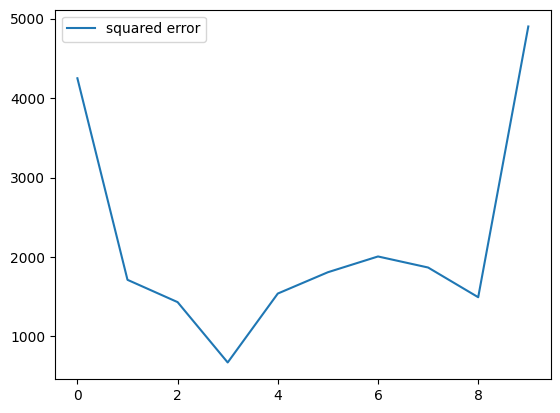

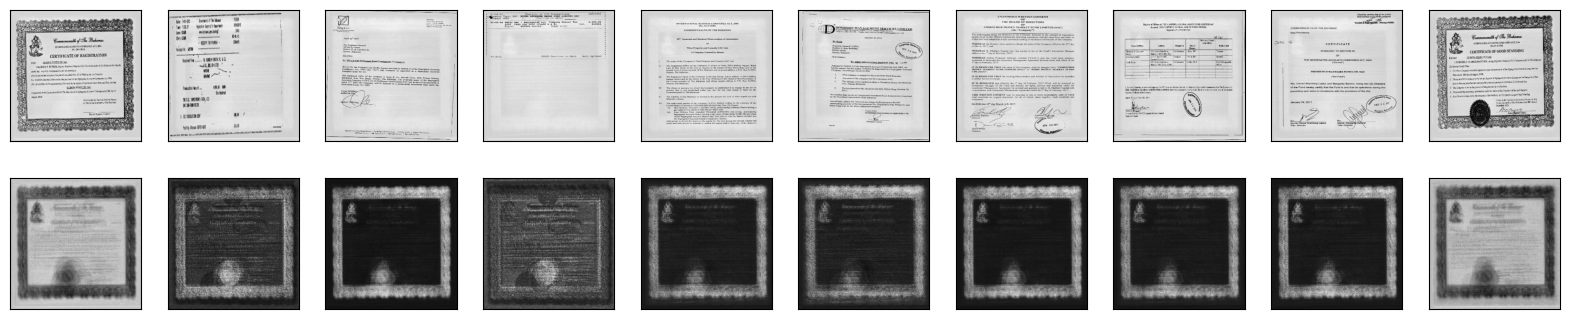

In [53]:
# plot squared error on validation set
x_test_pred = ae.predict(x_test)
x_residuals = [sum((x_pred - x)**2) for x_pred, x in zip(x_test_pred, x_test)]
plt.plot(x_residuals, label="squared error")
plt.legend()
plt.show()

# plot decoded images and originals
n = len(x_test)
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i - 1].reshape(IMG_SIZE, IMG_SIZE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_pred[i - 1].reshape(IMG_SIZE, IMG_SIZE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [23]:
# encode (compress) and decode (reconstruct) all images
encoded_images = encoder.predict(preprocessed_images_centered)
decoded_images = decoder.predict(encoded_images)

7/7 [==============================] - 0s 5ms/step


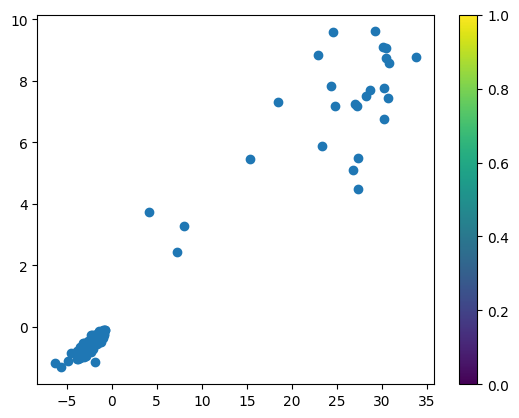

In [24]:
plt.figure()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1])
plt.colorbar()

In [25]:
# save representation of images
ae_2d_df = pd.DataFrame({'path': image_paths, 'ae': 0})
ae_2d_df.set_index('path', inplace=True)
# inserting a list in a cell, c.f. https://stackoverflow.com/questions/48000225/must-have-equal-len-keys-and-value-when-setting-with-an-iterable
for i in range(len(image_paths)):
    ae_2d_df.loc[[image_paths[i]], 'ae'] = pd.Series([encoded_images[i]], index=ae_2d_df.index[[i]])

ae_2d_df

,ae
path,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-2.2974536, -0.6410817]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-2.4211354, -0.53256243]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[4.168868, 3.747439]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-1.723662, -0.3383007]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-3.0207574, -0.73513186]"
...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-2.046946, -0.7281501]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-1.9817225, -0.5826806]"
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-1.0318564, -0.29061323]"


In [26]:
NUM_CLASSES = 4
d2_kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=0, n_init="auto").fit(ae_2d_df['ae'].to_list())
ae_2d_df['cluster'] = d2_kmeans.labels_
display(ae_2d_df)

,ae,cluster
path,,
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC45-53.png,"[-2.2974536, -0.6410817]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC196-8.png,"[-2.4211354, -0.53256243]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC104-6.png,"[4.168868, 3.747439]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC2-27.png,"[-1.723662, -0.3383007]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC18-7.png,"[-3.0207574, -0.73513186]",0
...,...,...
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC86-9.png,"[-2.046946, -0.7281501]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC32-4.png,"[-1.9817225, -0.5826806]",0
/Users/klara/Documents/Uni/bachelorarbeit/images/SAC41-12.png,"[-1.0318564, -0.29061323]",0


Text(0.5, 1.0, '2D representation of images clustered by KMeans')

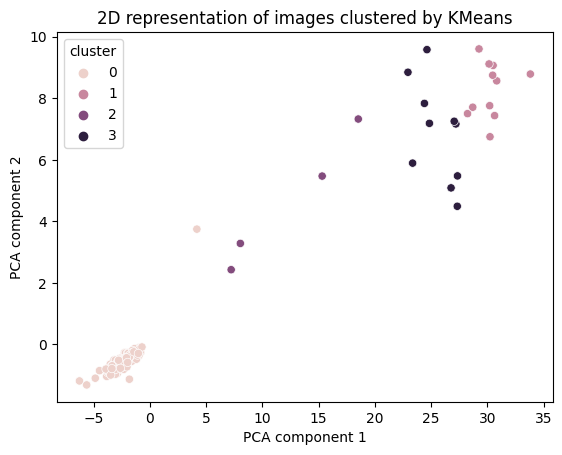

In [27]:
sns.scatterplot(x=ae_2d_df['ae'].apply(lambda x: x[0]), y=ae_2d_df['ae'].apply(lambda x: x[1]), hue=ae_2d_df['cluster'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('2D representation of images clustered by KMeans')

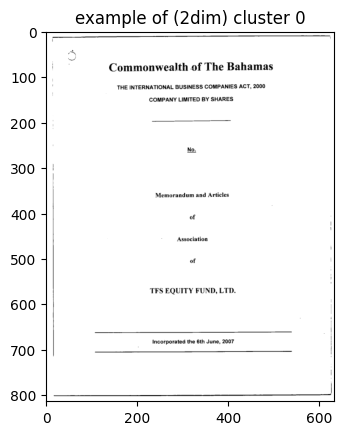

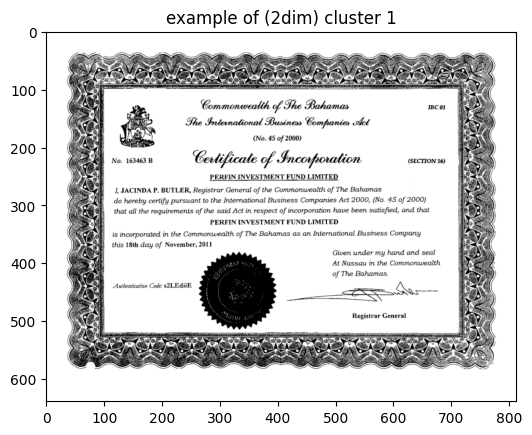

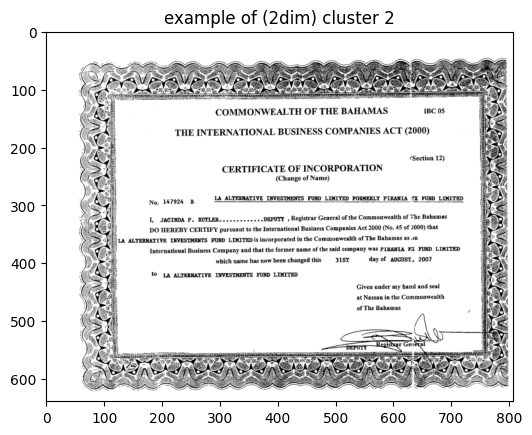

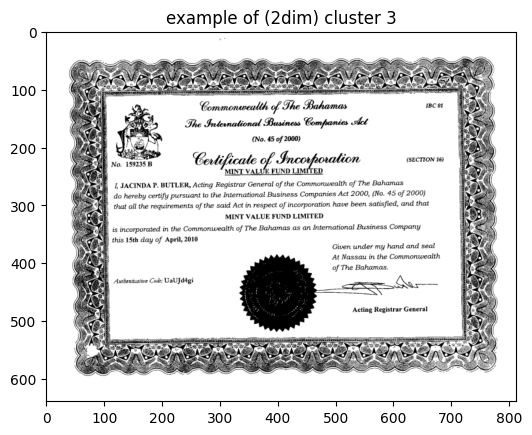

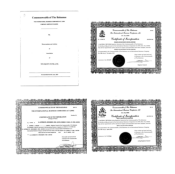

In [28]:
# display sample document per class
d2_example_images = []
for i in range(NUM_CLASSES):
    example_img = ae_2d_df[ae_2d_df['cluster'] == i].sample(1).index.values[0]
    d2_example_images.append(example_img)
    plt.imshow(cv2.imread(example_img, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('example of (2dim) cluster ' + str(i))
    plt.show()

create_image_matrix(d2_example_images, dim=int(math.sqrt(NUM_CLASSES)), output_path='/Users/klara/Downloads/')

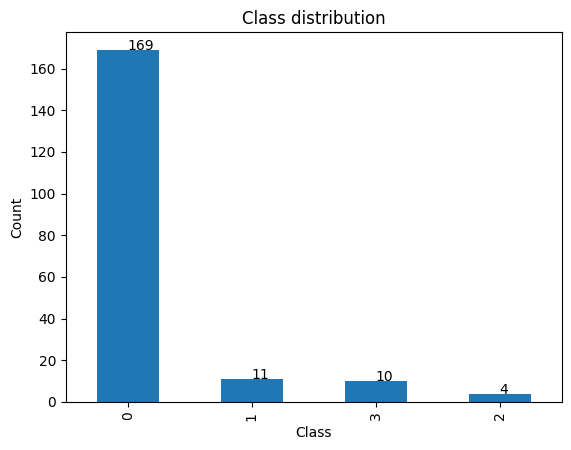

In [29]:
# class/ cluster distribution
ae_2d_df['cluster'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count')
d2_cluster_counts = ae_2d_df['cluster'].value_counts().sort_values(inplace=False, ascending=False).values
# adding labels to bars, c.f. https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
for i in range(len(ae_2d_df['cluster'].value_counts())):
        plt.text(i, d2_cluster_counts[i], d2_cluster_counts[i])